In [1]:
# Import libraries
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
# Download necessary NLTK data (run once)
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
spam = pd.read_csv("spam.csv", encoding='latin1')

In [4]:
spam.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:

spam = spam[['v1', 'v2']]
spam = spam.rename(columns={'v1': 'target', 'v2': 'text'})


In [6]:
spam.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
lb = LabelEncoder()
spam['target'] = lb.fit_transform(spam['target'])

In [8]:
spam.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
pam = spam.drop_duplicates(keep='first')

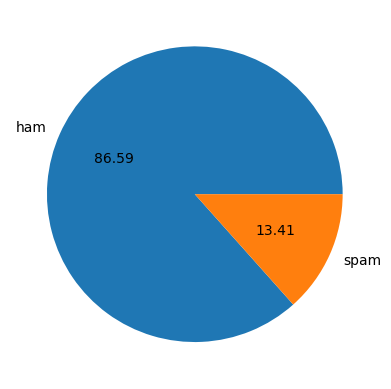

In [10]:
plt.pie(spam['target'].value_counts(),labels=['ham','spam'],autopct='%0.2f')
plt.show()

In [11]:
spam['number_of_characters'] = spam['text'].apply(len)
spam['number_of_words'] = spam['text'].apply(lambda x: len(nltk.word_tokenize(x)))
spam['number_of_sentences'] = spam['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [12]:
spam[['number_of_characters','number_of_words','number_of_sentences']].describe()

,number_of_characters,number_of_words,number_of_sentences
count,5572.000000,5572.000000,5572.000000
mean,80.118808,18.699390,1.996411
std,59.690841,13.741932,1.520159
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,61.000000,15.000000,1.500000
75%,121.000000,27.000000,2.000000
max,910.000000,220.000000,38.000000


In [13]:
spam[spam ['target']==0][['number_of_characters','number_of_words','number_of_sentences']].describe()

,number_of_characters,number_of_words,number_of_sentences
count,4825.000000,4825.000000,4825.000000
mean,71.023627,17.276269,1.837720
std,58.016023,13.988585,1.454388
min,2.000000,1.000000,1.000000
25%,33.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,92.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [14]:
spam[spam ['target']==1][['number_of_characters','number_of_words','number_of_sentences']].describe()

,number_of_characters,number_of_words,number_of_sentences
count,747.000000,747.000000,747.000000
mean,138.866131,27.891566,3.021419
std,29.183082,6.867007,1.537580
min,13.000000,2.000000,1.000000
25%,132.500000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


<Axes: xlabel='number_of_characters', ylabel='Count'>

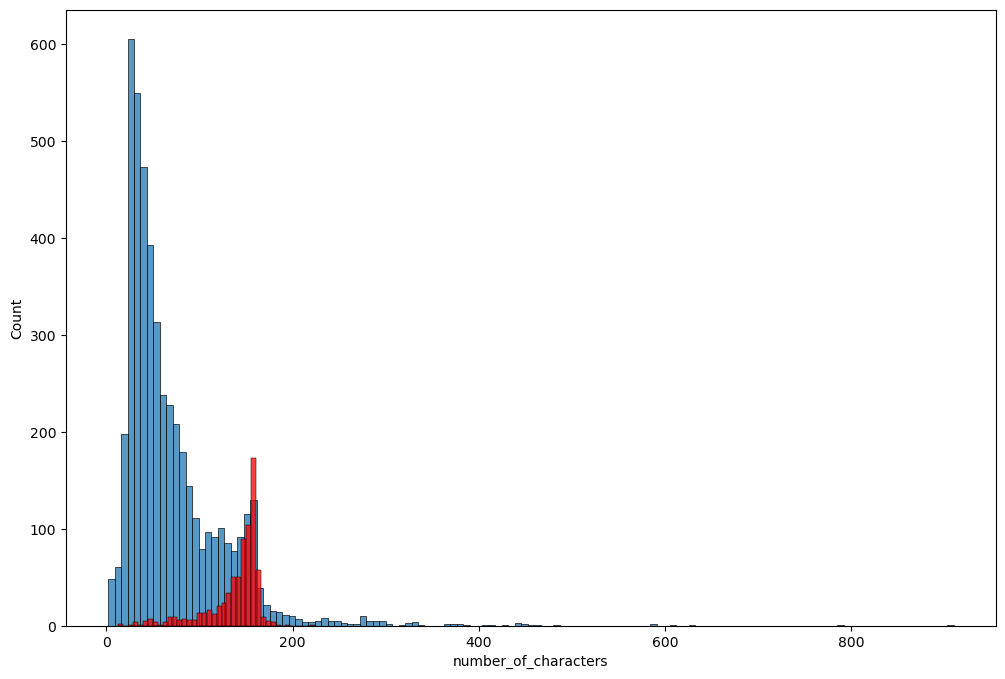

In [15]:
plt.figure(figsize=(12,8))
sns.histplot(spam[spam['target']==0]['number_of_characters'])
sns.histplot(spam[spam['target']==1]['number_of_characters'],color='red')

<Axes: xlabel='number_of_words', ylabel='Count'>

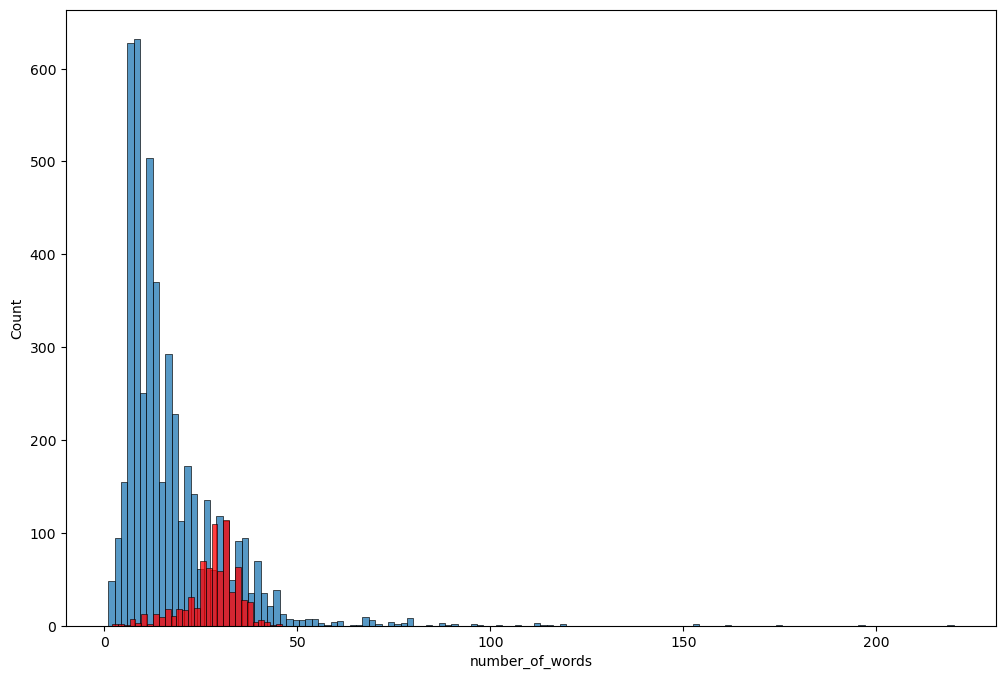

In [16]:
plt.figure(figsize=(12,8))
sns.histplot(spam[spam['target']==0]['number_of_words'])
sns.histplot(spam[spam['target']==1]['number_of_words'],color='red')

<Axes: >

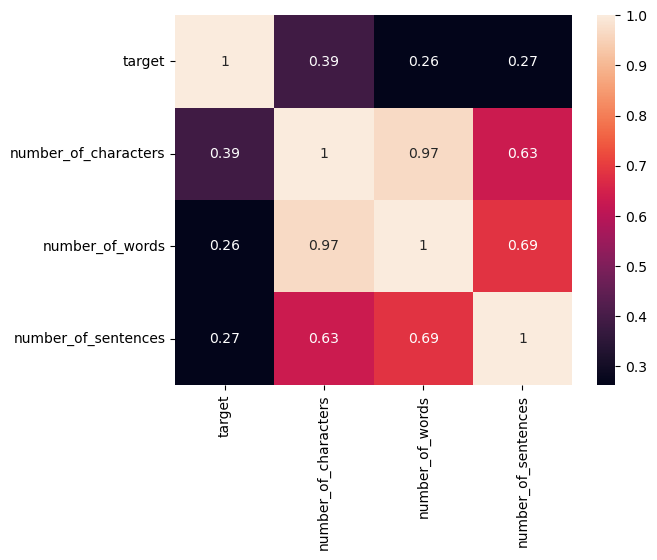

In [17]:
sns.heatmap(spam[['target','number_of_characters','number_of_words','number_of_sentences']].corr(),annot=True)

In [18]:
spam.sample(5)

,target,text,number_of_characters,number_of_words,number_of_sentences
2529,0,Can you just come in for a sec? There's somebo...,71,18,2
5007,0,Go fool dont cheat others ok,28,6,1
274,0,No objection. My bf not coming.,31,8,2
622,0,MAKE SURE ALEX KNOWS HIS BIRTHDAY IS OVER IN F...,87,17,1
831,0,Hi mate its RV did u hav a nice hol just a mes...,130,31,1


In [19]:
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))


In [20]:
def transform_text(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]  # keep alphanumeric only
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    tokens = [ps.stem(word) for word in tokens]
    return " ".join(tokens)


In [21]:
spam['transformed_text'] = spam['text'].apply(transform_text)

In [22]:
spam_corpus=[]
for msg in spam[spam['target']==1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [23]:
len(spam_corpus)

11490

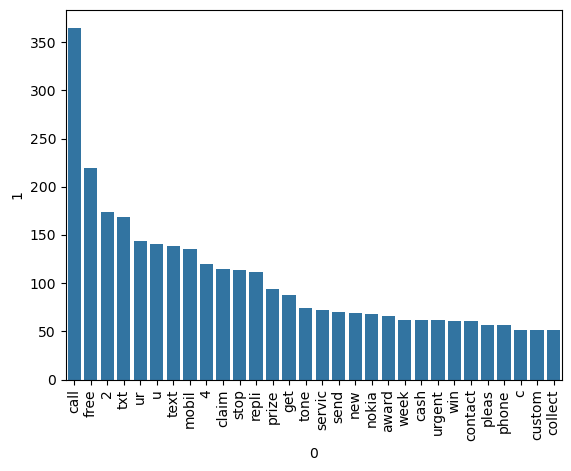

In [24]:
from collections import Counter
sns.barplot(x=pd.DataFrame(Counter(spam_corpus).most_common(30))[0],y=pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation=90)
plt.show()

In [25]:
cv = CountVectorizer()
X = cv.fit_transform(spam['transformed_text']).toarray()
y = spam['target'].values

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [28]:
y_pred = lr.predict(X_test)
print("CountVectorizer Model:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))


CountVectorizer Model:
Accuracy: 0.9775784753363229
Confusion Matrix:
 [[965   0]
 [ 25 125]]
Precision: 1.0


In [29]:
tfidf = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf.fit_transform(spam['transformed_text']).toarray()



In [30]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42)

In [31]:
lr_tfidf = LogisticRegression(max_iter=1000)
lr_tfidf.fit(X_train_tfidf, y_train_tfidf)

LogisticRegression(max_iter=1000)

In [32]:
y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)
print("\nTF-IDF Vectorizer Model:")
print("Accuracy:", accuracy_score(y_test_tfidf, y_pred_tfidf))
print("Confusion Matrix:\n", confusion_matrix(y_test_tfidf, y_pred_tfidf))
print("Precision:", precision_score(y_test_tfidf, y_pred_tfidf))


TF-IDF Vectorizer Model:
Accuracy: 0.9461883408071748
Confusion Matrix:
 [[961   4]
 [ 56  94]]
Precision: 0.9591836734693877


In [33]:
pickle.dump(cv, open('vectorizer.pkl', 'wb'))
pickle.dump(lr, open('model.pkl', 'wb'))